## 自制数据集

制作数据集我们需要训练用的二图片和标签文件，因此制作一个函数把图片路径(.jpg)和标签文件(.txt)作为一个函数的参数传进去，然后得到数据集。其中标签文件每一行文件名和标签对应，中间用空格隔开

In [9]:
def generateds(path,txt):
    f=open(txt,'r')
    contents=f.readlines()
    f.close()
    x,y_=[],[]
    for content in contents:
        value=content.split()#用空格分开
        img_path=path+value[0]
        img=Image.open(img_path)
        img=np.array(img.convert('L'))#L表示灰度图像.
        img=img/255.
        x.append(img)
        y_.append(value[1])
        print('loading:'+content)
    x=np.array(x)
    y_=np.array(y_)
    y_=y_.astype(np.int64)
    return x,y_

更进一步的制作需要

In [10]:
from PIL import Image
import numpy as np
import os

train_path='C:\\GAN\\RESULTS\\tmp3emkobse\\'
train_txt='C:\python_work\datasets\mhganfigures.txt'
x_train_savepath='.\datasets\cf10_x.npy'
y_train_savepath='.\datasets\cf10_y.npy'

if os.path.exists(x_train_savepath)and os.path.exists(y_train_savepath):
    print('------------load Datasets-------------')
    x_train_save=np.load(x_train_savepath)
    y_train=np.load(y_train_savepath)
    x_train=np.reshape(x_train_save,(len(x_train_save),530,530))#由打平的数组变成原图像
else:
    print('----------Generate Datasets-----------')
    x_train,y_train=generateds(train_path,train_txt)
    
    print('----------Save Datasets----------')
    x_train_save=np.reshape(x_train,(len(x_train),-1))#打平由(7, 530, 530)变成(7, 280900)
    np.save(x_train_savepath,x_train_save)
    np.save(y_train_savepath,y_train)

------------load Datasets-------------


## 数据增强

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen_train=ImageDataGenerator(
    rescale=1.0/1.0,#如果是图像，分母为255时，可以归至0-1
    rotation_range=45,#随机45度旋转，可以是区间表示范围
    width_shift_range=0.15,#随机宽度偏移量
    height_shift_range=0.15,#
    horizontal_flip=False,#水平翻转
    zoom_range=0.5)#将图像随机缩放，范围([1-n,1+n])

这里的fit需要输入一个四维数组（四通道），因此需要进行reshape

In [17]:
x_train=x_train.reshape(x_train.shape[0],530,530,1)
image_gen_train.fit(x_train)

## 利用增强的图片数据进行训练

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

fashion=tf.keras.datasets.fashion_mnist
(x_train,y_train),(x_test,y_test)=fashion.load_data()
x_train,x_test=x_train/255,x_test/255
x_train=x_train.reshape(x_train.shape[0],28,28,1)

image_gen_train=ImageDataGenerator(
    rescale=1.0/1.0,#如果是图像，分母为255时，可以归至0-1
    rotation_range=45,#随机45度旋转，可以是区间表示范围
    width_shift_range=0.15,#随机宽度偏移量
    height_shift_range=0.15,#
    horizontal_flip=True,#水平翻转
    zoom_range=0.5)#将图像随机缩放，范围([1-n,1+n])
image_gen_train.fit(x_train)

model=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['sparse_categorical_accuracy'])
model.fit(image_gen_train.flow(x_train,y_train,batch_size=32),epochs=5,validation_data=(x_test,y_test),validation_freq=1)#以flow形式打包喂入网络
model.summary()

Train for 1875 steps, validate on 10000 samples
Epoch 1/5
1875/1875 [==============================] - 24s 13ms/step - loss: 1.5172 - sparse_categorical_accuracy: 0.4543 - val_loss: 1.0023 - val_sparse_categorical_accuracy: 0.6530
Epoch 2/5
1875/1875 [==============================] - 24s 13ms/step - loss: 1.2771 - sparse_categorical_accuracy: 0.5404 - val_loss: 0.9645 - val_sparse_categorical_accuracy: 0.6563
Epoch 3/5
1875/1875 [==============================] - 27s 14ms/step - loss: 1.2017 - sparse_categorical_accuracy: 0.5653 - val_loss: 0.8727 - val_sparse_categorical_accuracy: 0.6787
Epoch 4/5
1875/1875 [==============================] - 24s 13ms/step - loss: 1.1543 - sparse_categorical_accuracy: 0.5820 - val_loss: 0.8932 - val_sparse_categorical_accuracy: 0.6673
Epoch 5/5
1875/1875 [==============================] - 27s 14ms/step - loss: 1.1263 - sparse_categorical_accuracy: 0.5909 - val_loss: 0.9051 - val_sparse_categorical_accuracy: 0.6380
Model: "sequential_3"
_______________

## 断点续训

In [18]:
import tensorflow as tf
import os

mnist=tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train,x_test=x_train/255.,x_test/255.

model=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')
])

checkpoint_save_path='.\checkpoint\mnist.ckpt'
if os.path.exists(checkpoint_save_path+'.index'):
    print('------------load the model----------')
    model.load_weights(checkpoint_save_path)
    
cp_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                              save_weights_only=True,#只保留权重
                                              save_best_only=True)#只保留最优

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['sparse_categorical_accuracy'])

history=model.fit(x_train,y_train,batch_size=32,epochs=5,validation_data=(x_test,y_test),validation_freq=1,
                 callbacks=[cp_callback])
model.summary()

------------load the model----------
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 90us/sample - loss: 0.0060 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.1340 - val_sparse_categorical_accuracy: 0.9751
Epoch 2/5
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0041 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.1014 - val_sparse_categorical_accuracy: 0.9801
Epoch 3/5
60000/60000 [==============================] - 5s 76us/sample - loss: 0.0053 - sparse_categorical_accuracy: 0.9981 - val_loss: 0.0974 - val_sparse_categorical_accuracy: 0.9800
Epoch 4/5
60000/60000 [==============================] - 4s 73us/sample - loss: 0.0043 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.1138 - val_sparse_categorical_accuracy: 0.9781
Epoch 5/5
60000/60000 [==============================] - 4s 73us/sample - loss: 0.0055 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.1153 - val_sparse_categorical_

## 提取可训练参数

为了查看模型中可训练参数的值，我们可以用print函数，但直接使用print会出现很多省略号，因此，我们需要设置阈值<center>np.set_printoptions(threshold=np.inf)</center>其中threshold表示超过多少省略显示，在上一次代码的基础上继续完善

In [4]:
import tensorflow as tf
import os
import numpy as np

np.set_printoptions(threshold=np.inf)

mnist=tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train,x_test=x_train/255.,x_test/255.

model=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')
])

checkpoint_save_path='.\checkpoint\mnist.ckpt'
if os.path.exists(checkpoint_save_path+'.index'):
    print('------------load the model----------')
    model.load_weights(checkpoint_save_path)
    
cp_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                              save_weights_only=True,#只保留权重
                                              save_best_only=True)#只保留最优

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['sparse_categorical_accuracy'])

history=model.fit(x_train,y_train,batch_size=32,epochs=5,validation_data=(x_test,y_test),validation_freq=1,
                 callbacks=[cp_callback])
model.summary()

#print(model.trainable_variables)#为了美观，此行注释
file=open('.\weights.txt','w')
for v in model.trainable_variables:
    file.write(str(v.name)+'\n')
    file.write(str(v.shape)+'\n')
    file.write(str(v.numpy())+'\n')
file.close()

------------load the model----------
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 9s 143us/sample - loss: 0.0025 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.1314 - val_sparse_categorical_accuracy: 0.9764
Epoch 2/5
60000/60000 [==============================] - 8s 127us/sample - loss: 0.0048 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.1211 - val_sparse_categorical_accuracy: 0.9776
Epoch 3/5
60000/60000 [==============================] - 8s 125us/sample - loss: 0.0032 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.1287 - val_sparse_categorical_accuracy: 0.9792
Epoch 4/5
60000/60000 [==============================] - 8s 130us/sample - loss: 0.0037 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.1314 - val_sparse_categorical_accuracy: 0.9787
Epoch 5/5
60000/60000 [==============================] - 8s 129us/sample - loss: 0.0045 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.1399 - val_sparse_categor

## 可视化acc和loss

继续在上一次的代码上进行补充

------------load the model----------
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 9s 144us/sample - loss: 0.0028 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.1487 - val_sparse_categorical_accuracy: 0.9796
Epoch 2/5
60000/60000 [==============================] - 8s 128us/sample - loss: 0.0041 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.1546 - val_sparse_categorical_accuracy: 0.9770
Epoch 3/5
60000/60000 [==============================] - 8s 132us/sample - loss: 0.0019 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.1435 - val_sparse_categorical_accuracy: 0.9801
Epoch 4/5
60000/60000 [==============================] - 8s 126us/sample - loss: 0.0035 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.1496 - val_sparse_categorical_accuracy: 0.9790
Epoch 5/5
60000/60000 [==============================] - 8s 128us/sample - loss: 0.0042 - sparse_categorical_accuracy: 0.9986 - val_loss: 0.1496 - val_sparse_categor

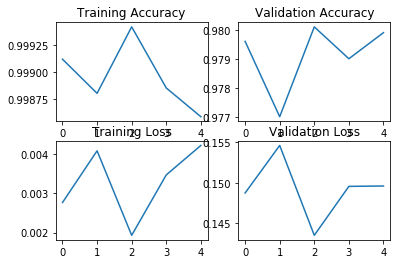

In [7]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

mnist=tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train,x_test=x_train/255.,x_test/255.

model=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')
])

checkpoint_save_path='.\checkpoint\mnist.ckpt'
if os.path.exists(checkpoint_save_path+'.index'):
    print('------------load the model----------')
    model.load_weights(checkpoint_save_path)
    
cp_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                              save_weights_only=True,#只保留权重
                                              save_best_only=True)#只保留最优

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['sparse_categorical_accuracy'])

history=model.fit(x_train,y_train,batch_size=32,epochs=5,validation_data=(x_test,y_test),validation_freq=1,
                 callbacks=[cp_callback])
model.summary()

acc=history.history['sparse_categorical_accuracy']
val_acc=history.history['val_sparse_categorical_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.subplot(2,2,1)
plt.plot(acc)
plt.title('Training Accuracy')
plt.subplot(2,2,2)
plt.plot(val_acc)
plt.title('Validation Accuracy')
plt.subplot(2,2,3)
plt.plot(loss)
plt.title('Training Loss')
plt.subplot(2,2,4)
plt.plot(val_loss)
plt.title('Validation Loss')
#plt.subplots_adjust(wspace=1.5,hspace=1)
plt.show()

## 绘图识物

------------load the model----------
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 137us/sample - loss: 0.0280 - sparse_categorical_accuracy: 0.9913 - val_loss: 0.0839 - val_sparse_categorical_accuracy: 0.9763
Epoch 2/5
60000/60000 [==============================] - 5s 90us/sample - loss: 0.0230 - sparse_categorical_accuracy: 0.9929 - val_loss: 0.0751 - val_sparse_categorical_accuracy: 0.9790
Epoch 3/5
60000/60000 [==============================] - 6s 92us/sample - loss: 0.0197 - sparse_categorical_accuracy: 0.9939 - val_loss: 0.0818 - val_sparse_categorical_accuracy: 0.9774
Epoch 4/5
60000/60000 [==============================] - 5s 85us/sample - loss: 0.0156 - sparse_categorical_accuracy: 0.9952 - val_loss: 0.0836 - val_sparse_categorical_accuracy: 0.9770
Epoch 5/5
60000/60000 [==============================] - 5s 90us/sample - loss: 0.0137 - sparse_categorical_accuracy: 0.9958 - val_loss: 0.0805 - val_sparse_categorical

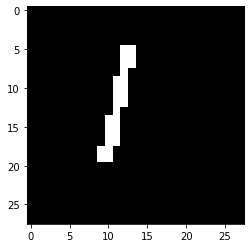



[4]
the path of test pictures2.jpg


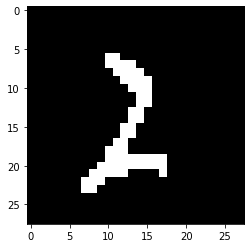



[1]
the path of test pictures6.jpg


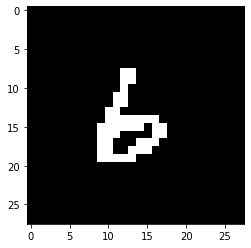



[6]


In [6]:
import tensorflow as tf
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

mnist=tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train,x_test=x_train/255.,x_test/255.

model=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')
])

checkpoint_save_path='.\checkpoint\mnist.ckpt'
if os.path.exists(checkpoint_save_path+'.index'):
    print('------------load the model----------')
    model.load_weights(checkpoint_save_path)
    
cp_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                              save_weights_only=True,#只保留权重
                                              save_best_only=True)#只保留最优

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['sparse_categorical_accuracy'])

history=model.fit(x_train,y_train,batch_size=32,epochs=5,validation_data=(x_test,y_test),validation_freq=1,
                 callbacks=[cp_callback])#预测结果时不用训练
model.summary()

preNum=int(input('input the number of test pictures:'))
for i in range(preNum):
    image_path=input('the path of test pictures')
    img=Image.open(image_path)
    img=img.resize((28,28),Image.ANTIALIAS)
    img_arr=np.array(img.convert('L'))
    
    #mnist数据集都是黑底白字，需要颜色反转，且增加对比度
    for i in range(28):
        for j in range(28):
            if img_arr[i][j]>160:
                img_arr[i][j]=0
            else:
                img_arr[i][j]=255
    #img_arr=255-img_arr#两种方法选其一就行
    plt.imshow(img_arr,cmap='gray')
    plt.show()
    img_arr=img_arr/255.
    x_predict=img_arr[tf.newaxis,...]#w喂入神经网络前都是按照batch送入，因此变成[1,28,28]大小的图片
    result=model.predict(x_predict)
    pred=tf.argmax(result,axis=1)
    print('\n')
    tf.print(pred)